In [1]:
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ekgus9","key":"e87e42ec6bf155bd3ad4d10dc4e5039c"}'}

In [2]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c sf-crime

sampleSubmission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
!unzip train.csv.zip
!unzip test.csv.zip
!unzip sampleSubmission.csv.zip

Archive:  train.csv.zip
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train.csv               
Archive:  test.csv.zip
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: test.csv                
Archive:  sampleSubmission.csv.zip
replace sampleSubmission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: sampleSubmission.csv    


In [4]:
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm

In [5]:
train = pd.read_csv('/content/LightGBM/python-package/train.csv')
test = pd.read_csv('/content/LightGBM/python-package/test.csv')
submission = pd.read_csv('/content/LightGBM/python-package/sampleSubmission.csv')

In [6]:
train.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


In [7]:
# 타입 확인
train.dtypes

Dates          object
Category       object
Descript       object
DayOfWeek      object
PdDistrict     object
Resolution     object
Address        object
X             float64
Y             float64
dtype: object

In [8]:
test.head()

,Id,Dates,DayOfWeek,PdDistrict,Address,X,Y
0,0,2015-05-10 23:59:00,Sunday,BAYVIEW,2000 Block of THOMAS AV,-122.399588,37.735051
1,1,2015-05-10 23:51:00,Sunday,BAYVIEW,3RD ST / REVERE AV,-122.391523,37.732432
2,2,2015-05-10 23:50:00,Sunday,NORTHERN,2000 Block of GOUGH ST,-122.426002,37.792212
3,3,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412
4,4,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878049 entries, 0 to 878048
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Dates       878049 non-null  object 
 1   Category    878049 non-null  object 
 2   Descript    878049 non-null  object 
 3   DayOfWeek   878049 non-null  object 
 4   PdDistrict  878049 non-null  object 
 5   Resolution  878049 non-null  object 
 6   Address     878049 non-null  object 
 7   X           878049 non-null  float64
 8   Y           878049 non-null  float64
dtypes: float64(2), object(7)
memory usage: 60.3+ MB


In [10]:
# 필요없는 변수 제거
test = test.drop('Id',axis = 1)
y_train = train['Category']
train = train.drop(['Category','Resolution','Descript'],axis = 1)

In [11]:
# null값 제거
train.isnull().sum()

Dates         0
DayOfWeek     0
PdDistrict    0
Address       0
X             0
Y             0
dtype: int64

In [12]:
test.isnull().sum()

Dates         0
DayOfWeek     0
PdDistrict    0
Address       0
X             0
Y             0
dtype: int64

In [13]:
# Dates
train['Dates'] = train['Dates'].astype('datetime64')
train['year'] = train['Dates'].dt.year
train['month'] = train['Dates'].dt.month
train['hour'] = train['Dates'].dt.hour

test['Dates'] = test['Dates'].astype('datetime64')
test['year'] = test['Dates'].dt.year
test['month'] = test['Dates'].dt.month
test['hour'] = test['Dates'].dt.hour

train = train.drop('Dates',axis = 1)
test = test.drop('Dates',axis = 1)

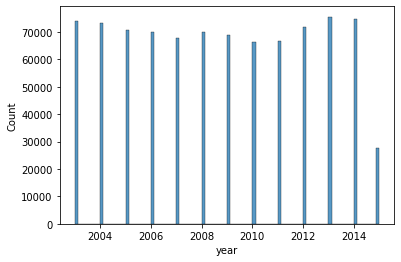

In [14]:
sns.histplot(data=train,x='year')

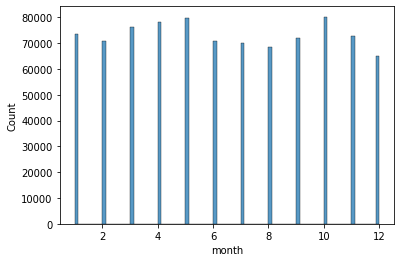

In [15]:
sns.histplot(data=train,x='month')

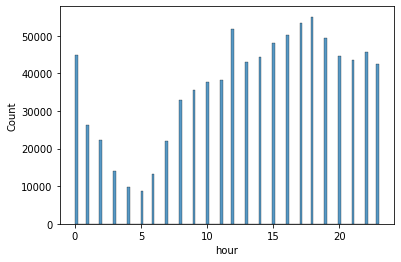

In [16]:
sns.histplot(data=train,x='hour')

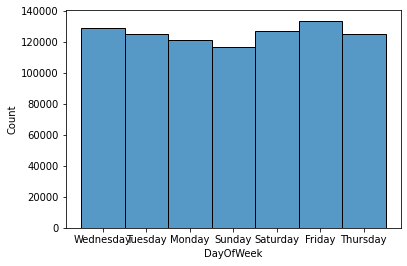

In [17]:
sns.histplot(data=train,x='DayOfWeek')

In [18]:
from sklearn.preprocessing import LabelEncoder
lb = LabelEncoder()
train['year'] = lb.fit_transform(train['year'])
train['month'] = lb.fit_transform(train['month'])
train['hour'] = lb.fit_transform(train['hour'])
train['DayOfWeek'] = lb.fit_transform(train['DayOfWeek'])

test['year'] = lb.fit_transform(test['year'])
test['month'] = lb.fit_transform(test['month'])
test['hour'] = lb.fit_transform(test['hour'])
test['DayOfWeek'] = lb.fit_transform(test['DayOfWeek'])

In [19]:
# submission 파일에서 label 필요하기 때문에 따로 보관
LB = LabelEncoder()
y_train = LB.fit_transform(y_train)

In [20]:
# PdDistrict
train['PdDistrict'].value_counts()

SOUTHERN      157182
MISSION       119908
NORTHERN      105296
BAYVIEW        89431
CENTRAL        85460
TENDERLOIN     81809
INGLESIDE      78845
TARAVAL        65596
PARK           49313
RICHMOND       45209
Name: PdDistrict, dtype: int64

In [21]:
train['PdDistrict'] = lb.fit_transform(train['PdDistrict'])
test['PdDistrict'] = lb.fit_transform(test['PdDistrict'])

In [22]:
# Address
train['Address'].unique

<bound method Series.unique of 0                 OAK ST / LAGUNA ST
1                 OAK ST / LAGUNA ST
2          VANNESS AV / GREENWICH ST
3           1500 Block of LOMBARD ST
4          100 Block of BRODERICK ST
                     ...            
878044    FARALLONES ST / CAPITOL AV
878045          600 Block of EDNA ST
878046            5TH ST / FOLSOM ST
878047          TOWNSEND ST / 2ND ST
878048      1800 Block of NEWCOMB AV
Name: Address, Length: 878049, dtype: object>

In [23]:
train['ST'] = train['Address'].str.contains('ST', case = False)
train['Block'] = train['Address'].str.contains('Block', case = False)
train['AV'] = train['Address'].str.contains('AV', case = False)
test['ST'] = test['Address'].str.contains('ST', case = False)
test['Block'] = test['Address'].str.contains('Block', case = False)
test['AV'] = test['Address'].str.contains('AV', case = False)

train = train.drop('Address',axis = 1)
test = test.drop('Address', axis = 1)

train['ST'] = lb.fit_transform(train['ST'])
train['Block'] = lb.fit_transform(train['Block'])
train['AV'] = lb.fit_transform(train['AV'])
test['ST'] = lb.fit_transform(test['ST'])
test['Block'] = lb.fit_transform(test['Block'])
test['AV'] = lb.fit_transform(test['AV'])

In [24]:
train['x+y'] = train['X'] + train['Y']
test['x+y'] = test['X'] + test['Y']
train['x-y'] = train['X'] - train['Y']
test['x-y'] = test['X'] - test['Y']

In [25]:
train.shape

(878049, 12)

In [26]:
test.shape

(884262, 12)

In [27]:
!git clone --recursive https://github.com/Microsoft/LightGBM
%cd /content/LightGBM
!mkdir build
!cmake -DUSE_GPU=1
!make -j$(nproc)
!sudo apt-get -y install python-pip
!sudo -H pip install setuptools pandas numpy scipy scikit-learn -U
%cd /content/LightGBM/python-package/
!sudo python setup.py install --precompile

fatal: destination path 'LightGBM' already exists and is not an empty directory.
/content/LightGBM
mkdir: cannot create directory ‘build’: File exists
-- OpenCL include directory: /usr/include
-- Boost version: 1.65.1
-- Found the following Boost libraries:
--   filesystem
--   system
-- Using _mm_prefetch
-- Using _mm_malloc
-- Configuring done
-- Generating done
-- Build files have been written to: /content/LightGBM
[  2%] Built target lightgbm_capi_objs
[ 89%] Built target lightgbm_objs
[ 97%] Built target lightgbm
[100%] Built target _lightgbm
Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-pip is already the newest version (9.0.1-2.3~ubuntu1.18.04.5).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
/content/LightGBM/python-package
running install
/usr/local/lib/python3.7/dist-packages/setuptools/command/install.py:37: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other stan

In [28]:
import lightgbm as lg
data_train = lg.Dataset(train, label = y_train, categorical_feature=["PdDistrict", "DayOfWeek"])
params = {
    'boosting': 'gbdt', 
    'objective': 'multiclass',
    'metrics' : 'multi_logloss',
    'num_class': 39,
    'verbosity': 1,
    'device_type':'gpu',
    'gpu_platform_id':0,
    'gpu_device_id':0,
    'max_depth': 6,
    'num_leaves': 51,
    'min_data_in_leaf' : 25,
    'feature_fraction': 0.79,
    'learning_rate': 0.01,
    }
lgb = lg.train(params, data_train, 120)

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1094
[LightGBM] [Info] Number of data points in the train set: 878049, number of used features: 12
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 9 dense feature groups (10.05 MB) transferred to GPU in 0.020184 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -6.363608
[LightGBM] [Info] Start training from score -2.435509
[LightGBM] [Info] Start training from score -7.679105
[LightGBM] [Info] Start training from score -8.019031
[LightGBM] [Info] Start training from score -3.173428
[LightGBM] [Info] Start training from score -5.314447
[LightGBM] [Info] Start training from score -5.958804
[LightGBM] [Info] Start training from score -2.

In [29]:
prediction = lgb.predict(test)

In [30]:
result = pd.DataFrame(prediction, columns = LB.inverse_transform(np.linspace(0, 38, 39, dtype='int16')),index=test.index)
result.to_csv('sampleSubmission.csv', index_label = 'Id')

In [31]:
#pd.read_csv('/content/LightGBM/python-package/sampleSubmission.csv')

In [32]:
!kaggle competitions submit -c sf-crime -f sampleSubmission.csv -m " "

100% 703M/703M [00:14<00:00, 50.6MB/s]
Successfully submitted to San Francisco Crime Classification